1. 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정
2. train loss, validation loss 감소 경향 확인 및 실제 요약문의 핵심 단어들이 요약 문장안에 포함되었는지 확인
3. Extractive 요약을 시도해보고 Abstractive 요약 결과와 비교(문법완성도, 핵심단어 포함 측면으로 나누어 비교하고 표로 정리)

In [1]:
from importlib.metadata import version
import nltk
import torch
import summa
import pandas as pd

print(nltk.__version__)
print(torch.__version__)
print(pd.__version__)
print(version('summa'))

3.9.2
2.5.1+cu121
2.3.3
1.2.0


In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")

('news_summary_more.csv', <http.client.HTTPMessage at 0x1f0f544ac90>)

In [3]:
# 우선 빠르게 비교하기 위해 nrows를 20000으로 설정
# 나중에 해당 파라미터 지울 예정
data = pd.read_csv('./news_summary_more.csv', encoding='iso-8859-1')

In [4]:
print(data.shape)
data.sample(10)

(98401, 2)


,headlines,text
22455,Received my very 1st National Award from Karun...,Amitabh Bachchan took to Twitter to share a po...
11028,Divorce was traumatic but glad I spent 16 yrs ...,Opening up on his divorce with his first wife ...
18839,CPI(M) MLA PK Sasi accused of sexual harassment,Communist Party of India (Marxist) Kerala unit...
8030,Government body holds workshop on developing '...,The National Mission for Clean Ganga organised...
83635,Yahoo to shut Ã¢ÂÂ¹193 crore app that it boug...,Yahoo has announced it is shutting down its Ne...
66397,N Korean economy expanding despite sanctions: ...,The North Korean economy is expanding despite ...
84054,Twitterati create memes of asanas on Internati...,Twitter users on Wednesday created memes using...
25599,4 held for assaulting cops near PM ModiÃ¢ÂÂs...,The West Bengal Police has arrested four peopl...
85218,RBI identifies 12 accounts with 25% bad loans ...,RBI has said 12 accounts representing about 25...
97985,"BJP just no. 3 or 4 in WB, canÃ¢ÂÂt take on ...",West Bengal CM Mamata Banerjee on Friday rejec...


# Step2. Data preprocess(Abstract)
분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정

In [5]:
print("number of unique smaple in text : ", data["text"].nunique())
print("number of unique sample in headlines : ", data["headlines"].nunique())

number of unique smaple in text :  98360
number of unique sample in headlines :  98280


## 데이터 정리하기

#### 중복값 제거
Headline은 중복돼도 되지만, text는 중복된 샘플은 제외해주자

In [6]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset=["text"], inplace=True)
print("total number of samples : ", len(data))

total number of samples :  98360


#### Empty sample 제거
null값에 대해서도 drop해주자

In [7]:
print(data.isnull().sum())

data.dropna(axis=0, inplace=True)
print("total number of samples : ", len(data))

headlines    0
text         0
dtype: int64
total number of samples :  98360


#### text normalization & stopwords 처리

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [9]:
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\suhol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
print('number of stopwords :', len(stopwords.words('english') ))
print(stopwords.words('english'))

number of stopwords : 198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'sam

stopwords는 "text"에 대해서만 제거하고 "headlines"에는 따로 처리하지 않음  
나중에 원문을 요약하여 요약문을 생성할 때, 해당 요약문에는 stopwords가 남아있어야 자연스러움

In [11]:
from bs4 import BeautifulSoup
import re

def preprocess_sentence(sentence, remove_stopwords=True):
    # 텍스트 소문자화
    sentence = sentence.lower() 

    # <br />, <a href = ...> 등의 html 태그 제거
    sentence = BeautifulSoup(sentence, "lxml").text 

    # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub(r'\([^)]*\)', '', sentence)

    # 쌍따옴표 " 제거 
    sentence = re.sub('"','', sentence) 

    # 약어 정규화
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) 
    
    # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub(r"'s\b","", sentence) 
   
    # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub("[^a-zA-Z]", " ", sentence) 
   
    # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    sentence = re.sub('[m]{2,}', 'mm', sentence) 

    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() 
                          if not word in stopwords.words('english') 
                          if len(word) > 1)

    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [12]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


#### 전처리 시작

In [13]:
clean_text = []
temp = (len(data["text"]) / 10)
temp2 = 0

for i, sentence in enumerate(data["text"]):
    clean_text.append(preprocess_sentence(sentence))
    if i % temp == 0:
        print(f"[{temp2}%] preprocessing ...")
        temp2 += 10

# 전처리 후 결과 출력
print("result : ", clean_text[:5])

[0%] preprocessing ...
[10%] preprocessing ...
[20%] preprocessing ...
[30%] preprocessing ...
[40%] preprocessing ...
[50%] preprocessing ...
[60%] preprocessing ...
[70%] preprocessing ...
[80%] preprocessing ...
[90%] preprocessing ...
result :  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating b

In [14]:
clean_headlines = []
temp = (len(data["headlines"]) / 10)
temp2 = 0

for i, sentence in enumerate(data["headlines"]):
    clean_headlines.append(preprocess_sentence(sentence))
    if i % temp == 0:
        print(f"[{temp2}%] preprocessing ...")
        temp2 += 10

# 전처리 후 결과 출력
print("result : ", clean_headlines[:5])

[0%] preprocessing ...
[10%] preprocessing ...
[20%] preprocessing ...
[30%] preprocessing ...
[40%] preprocessing ...
[50%] preprocessing ...
[60%] preprocessing ...
[70%] preprocessing ...
[80%] preprocessing ...
[90%] preprocessing ...
result :  ['upgrad learner switches career ml al salary hike', 'delhi techie wins free food swiggy one year cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'known hirani yrs metoo claims true sonam']


전처리 이후 text와 headlines에 대해 다시 한번 empty sample이 생겼는지 확인

In [15]:
import numpy as np

data["text"] = clean_text
data["headlines"] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

# Null이 있는지 확인
print(data.isnull().sum())

# drop Null samples
data.dropna(axis=0, inplace=True)
print('number of total sample :', (len(data)))

headlines    0
text         0
dtype: int64
number of total sample : 98360


text's min len : 1
text's max len : 60
text's average len : 35.09968483123221
headlines's min len : 1
headlines's max len : 13
headlines's average len : 7.136183407889386


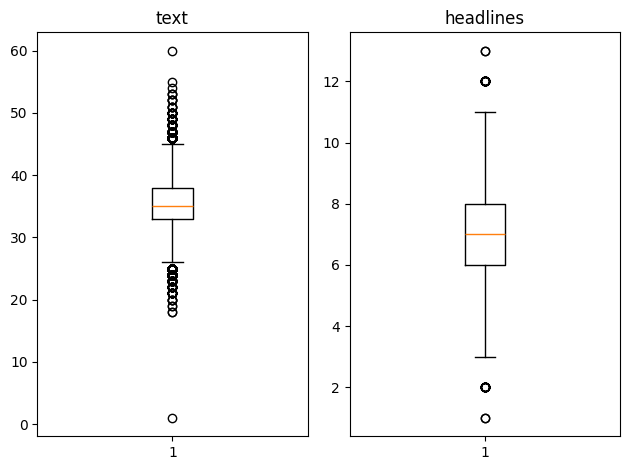

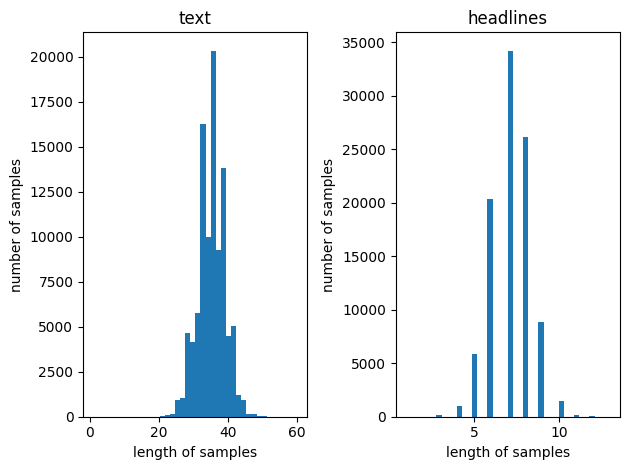

In [16]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('text\'s min len : {}'.format(np.min(text_len)))
print('text\'s max len : {}'.format(np.max(text_len)))
print('text\'s average len : {}'.format(np.mean(text_len)))
print('headlines\'s min len : {}'.format(np.min(headlines_len)))
print('headlines\'s max len : {}'.format(np.max(headlines_len)))
print('headlines\'s average len : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.subplot(1, 2, 1)
plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')

plt.subplot(1, 2, 2)
plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.tight_layout()
plt.show()

- text : min_len=1, max_len=60, average_len=35
- headlines = min_len=1, max_len=13, average_len=7

In [17]:
# text와 headlines의 최대 길이 설정
# (과도한 padding을 막기 위해 histogram 상에서 빈도가 크게 작아지는 부분을 상한으로 제한)
text_max_len = 44
headlines_max_len = 10

In [18]:
# 전체 data에 대하여 max_len에 걸리는 data가 몇 %인지 확인
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if len(s.split()) <= max_len:
            cnt += 1
    print(f"Percentage of samples below {max_len} : {cnt/len(nested_list)*100}%")

below_threshold_len(text_max_len, data["text"])
below_threshold_len(headlines_max_len, data["headlines"])

Percentage of samples below 44 : 99.33712891419276%
Percentage of samples below 10 : 99.7834485563237%


In [19]:
# max_len을 초과하는 sample 자르기 전에 전체 샘플 수 확인
print('total num of samples before cutting :', (len(data)))

# max_len 초과 샘플 자르기
data = data[data["text"].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data["headlines"].apply(lambda x: len(x.split()) <= headlines_max_len)]

# 확인
print('total num of samples after cutting :', (len(data)))

total num of samples before cutting : 98360
total num of samples after cutting : 97516


### 훈련 데이터와 테스트 데이터 나누기

#### Seq2Seq
- Encoder input = text(news 전체 내용)
- Decoder input/target = headlines(news의 headlines(정답 요약본))  

Decoder는 headlines을 한 글자/한 단어씩 생성하도록 학습

In [20]:
# seq2seq 훈련을 위해 decoder의 input, target에 SOS, EOS 추가
data["decoder_input"] = data["headlines"].apply(lambda x : "sostoken " + x)
data["decoder_target"] = data["headlines"].apply(lambda x : x + " eostoken")
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches career ml al salary hike,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches career ml al ...,upgrad learner switches career ml al salary hi...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,known hirani yrs metoo claims true sonam,speaking sexual harassment allegations rajkuma...,sostoken known hirani yrs metoo claims true sonam,known hirani yrs metoo claims true sonam eostoken
5,rahat fateh ali khan denies getting notice smu...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice smu...


In [21]:
# 인코더의 입력
encoder_input = np.array(data["text"])

# 디코더의 입력과 정답 레이블
decoder_input = np.array(data["decoder_input"])
decoder_target = np.array(data["decoder_target"])

이제 각각의 데이터를 훈련 데이터와 테스트 데이터로 분리하자

In [22]:
# 정수 시퀀스를 통해 각 데이터를 shuffle 
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)
print("===============================")

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

# 8:2 비율로 각각의 데이터 나누기
n_of_test = int(len(encoder_input)*0.2)
print("number of test samples : ", n_of_test)
print("===============================")

encoder_input_train = encoder_input[:-n_of_test]
decoder_input_train = decoder_input[:-n_of_test]
decoder_target_train = decoder_target[:-n_of_test]

encoder_input_test = encoder_input[:n_of_test]
decoder_input_test = decoder_input[:n_of_test:]
decoder_target_test = decoder_target[:n_of_test:]

print('number of train sample :', len(encoder_input_train))
print('number of train label :', len(decoder_input_train))
print('number of test sample :', len(encoder_input_test))
print('number of test label :', len(decoder_input_test))
print("===============================")


# 잘 나누어졌는지 확인
if len(decoder_input_test) + len(decoder_input_train) == len(decoder_input):
    print("Good")

[ 4606 78213 47054 ... 20773 35923 49334]
number of test samples :  19503
number of train sample : 78013
number of train label : 78013
number of test sample : 19503
number of test label : 19503
Good


### 정수 인코딩
- Vocab 만들기
    - 기계가 텍스트를 숫자로 처리할 수 있도록 각 데이터의 단어들을 모두 정수로 변환
    - 각 단어에 고유한 정수를 맵핑

먼저 encoder에 사용할 데이터부터 처리해주자

In [23]:
from collections import Counter

def src_tokenizer(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)
    return text.split()

def build_vocab(texts):
    vocab = {"<PAD>": 0, "<UNK>": 1}
    word_counter = Counter()

    for text in texts:
        # word_counter에 딕셔너리 형태로 업데이트 됨(word: 빈도수)
        word_counter.update(src_tokenizer(text))
    
    # vocab에 단어와 정수 맵핑
    # word_counter.most_common(): 빈도수 기준으로 정렬
    for word, _ in word_counter.most_common():
        if word not in vocab:
            vocab[word] = len(vocab)

    return vocab

# 입력 데이터로부터 단어 집합 생성
src_vocab = build_vocab(encoder_input_train)

In [24]:
threshold = 5

# 전처리된 데이터 사용
text_data = data['text'].tolist()
headlines_data = data['headlines'].tolist()

# encoder의 input이 되는 text_data의 단어 빈도수 계산
word_counter = Counter()
for text in text_data:
    word_counter.update(text.split())

total_cnt = len(word_counter)  # 전체 단어 개수
total_freq = sum(word_counter.values())  # 전체 단어 등장 횟수
rare_cnt = sum(1 for count in word_counter.values() if count < threshold)  # 희귀 단어 개수
rare_freq = sum(count for count in word_counter.values() if count < threshold)  # 희귀 단어 등장 횟수

# 희귀 단어를 제외한 단어 사전 구축
vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩 및 미등록 단어 추가
word_index = {word: idx + 2 for idx, (word, count) in enumerate(word_counter.items()) 
              if count >= threshold}

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 75665
등장 빈도가 4번 이하인 희귀 단어의 수: 46766
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 28899
단어 집합에서 희귀 단어의 비율: 61.80664772351814
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.32267842695504


"text" 에서 각각의 word에 대하여 등장빈도가 threshold(=5) 미만, 즉 4 이하인 단어들은 너무 희귀한 단어들이기 때문에 모델이 패턴을 잡아내기 어려움... 따라서 제거  
  
그리고 코드 실행 결과, 4번 이하인 희귀 단어를 제외했을 때 Vocab의 크기가 28899 이므로, vocab의 크기를 29000으로 제한  
만약, 메모리 속도와 효율을 생각하여 Vocab의 크기를 25000 으로도 줄일 수 있음

In [25]:
src_vocab_size = 29000

def build_limited_vocab(texts, vocab_size):
    vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩과 UNK 토큰 추가
    word_counter = Counter()

    for text in texts:
        word_counter.update(src_tokenizer(text))

    # 빈도가 높은 상위 vocab_size - 2개 단어만 선택 (PAD, UNK 포함)
    # vocab_size를 29000으로 설정하더라도 등장빈도가 threhold 미만인 단어는 포함되지 않음
    # 결국 28899개의 word로만 vocab_size가 결정됨 
    for word, _ in word_counter.most_common(vocab_size - 2):
        vocab[word] = len(vocab)

    return vocab

src_vocab = build_limited_vocab(encoder_input_train, src_vocab_size)

In [26]:
# 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터 단어들을 모두 정수로 변환
def text_to_sequence(texts, vocab):
    sequences = []
    for text in texts:
        sequence = [vocab.get(word, vocab["<UNK>"]) for word in src_tokenizer(text)]
        sequences.append(sequence)
    return sequences

# 텍스트 데이터 정수 시퀀스로 변환
encoder_input_train_seq = text_to_sequence(encoder_input_train, src_vocab)
encoder_input_test_seq = text_to_sequence(encoder_input_test, src_vocab)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train_seq[:3])
print(encoder_input_test_seq[:3])

[[704, 57, 95, 2667, 120, 22029, 393, 4770, 1564, 7297, 488, 20542, 1634, 752, 325, 7297, 1483, 704, 6496, 4158, 4771, 728, 2479, 704, 113, 8356, 8925, 1169, 770, 3838, 528, 110, 393], [747, 450, 513, 255, 126, 2685, 2259, 185, 20, 1318, 278, 6658, 1120, 485, 2082, 897, 218, 31, 842, 56, 3200, 2259, 654, 897, 218, 2440, 72, 2082, 897, 218, 72, 105, 2082, 214, 20, 1318, 278, 211, 3200], [613, 407, 2248, 10185, 1909, 4970, 809, 2480, 4580, 3499, 760, 1068, 1635, 3740, 12122, 760, 1987, 4885, 14188, 150, 2133, 4393, 254, 23853, 819, 1694, 2, 476, 3549, 2281, 1, 72, 989, 4970, 2110, 1909, 3414, 695, 102]]
[[704, 57, 95, 2667, 120, 22029, 393, 4770, 1564, 7297, 488, 20542, 1634, 752, 325, 7297, 1483, 704, 6496, 4158, 4771, 728, 2479, 704, 113, 8356, 8925, 1169, 770, 3838, 528, 110, 393], [747, 450, 513, 255, 126, 2685, 2259, 185, 20, 1318, 278, 6658, 1120, 485, 2082, 897, 218, 31, 842, 56, 3200, 2259, 654, 897, 218, 2440, 72, 2082, 897, 218, 72, 105, 2082, 214, 20, 1318, 278, 211, 3200], [6

이제 decoder에 들어갈 데이터도 처리해주자

In [27]:
def tar_tokenizer(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)
    return text.split()

# build_vocab은 encoder input에 대해 처리할 때 생성한 함수 그대로 사용
tar_vocab = build_vocab(decoder_input_train)

In [28]:
threshold = 5

word_counter = Counter()
for text in decoder_input_train:
    word_counter.update(tar_tokenizer(text))  # 각 문장의 단어 빈도 계산

# 전체 단어 개수 및 등장 빈도 계산
total_cnt = len(word_counter)  # 전체 단어 개수
total_freq = sum(word_counter.values())  # 전체 단어 등장 횟수
rare_cnt = sum(1 for count in word_counter.values() if count < threshold)  # 희귀 단어 개수
rare_freq = sum(count for count in word_counter.values() if count < threshold)  # 희귀 단어 등장 횟수

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29789
등장 빈도가 4번 이하인 희귀 단어의 수: 18411
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11378
단어 집합에서 희귀 단어의 비율: 61.80469300748599
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.0154419620523845


threshold는 일단 동일하게 설정

In [29]:
tar_vocab_size = 11500
tar_vocab = build_limited_vocab(decoder_input_train + decoder_target_train, tar_vocab_size)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train_seq = text_to_sequence(decoder_input_train, tar_vocab)
decoder_target_train_seq = text_to_sequence(decoder_target_train, tar_vocab)
decoder_input_test_seq = text_to_sequence(decoder_input_test, tar_vocab)
decoder_target_test_seq = text_to_sequence(decoder_target_test, tar_vocab)

# 잘 변환되었는지 확인
print('input')
print('input ', decoder_input_train_seq[:5])
print('target')
print('decoder ', decoder_target_train_seq[:5])

input
input  [[2, 424, 3791, 2709, 5449, 6580], [2, 1380, 244, 10, 828, 619, 1667, 2246], [2, 365, 4297, 669, 3792, 8568, 987, 1027], [2, 10493, 122, 8184, 1580, 416, 229, 852, 499, 823, 61], [2, 442, 2126, 447, 7295, 7025, 583, 408]]
target
decoder  [[424, 3791, 2709, 5449, 6580, 3], [1380, 244, 10, 828, 619, 1667, 2246, 3], [365, 4297, 669, 3792, 8568, 987, 1027, 3], [10493, 122, 8184, 1580, 416, 229, 852, 499, 823, 61, 3], [442, 2126, 447, 7295, 7025, 583, 408, 3]]


희귀 단어의 삭제로 원래 길이가 짧던 headlines data(target data)는 길이가 0이 되는 empty sample이 생겼을 가능성이 있음  
따라서, 길이가 0인 sample들은 모두 삭제해줘야 함  
참고로 target에는 eostoken을 추가했으므로 길이가 1로 표시될 것임

In [30]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78013
훈련 레이블의 개수 : 78013
테스트 데이터의 개수 : 19503
테스트 레이블의 개수 : 19503


### 패딩
- 정수 시퀀스로 변경한 데이터에 대해, 서로 다른 길이의 sample들을 병렬 처리하기 위하여 같은 길이로 맞춰주기
- 이전에 지정했던 max_len으로 패딩 진행

In [31]:
from torch.nn.utils.rnn import pad_sequence

# 텐서 변환 함수 (리스트 → PyTorch 텐서)
def convert_to_tensor(sequences):
    return [torch.tensor(seq, dtype=torch.long) for seq in sequences]

# 패딩 적용 함수 (PyTorch `pad_sequence()` 활용)
def pad_sequences_pytorch(sequences, maxlen, padding_value=0):
    # 리스트를 텐서로 변환
    sequences = convert_to_tensor(sequences)  

    # 패딩 적용
    padded_seqs = pad_sequence(sequences, 
                               batch_first=True, 
                               padding_value=padding_value)

    # maxlen 길이로 자르기 (최대 길이 초과 방지)
    return padded_seqs[:, :maxlen]  

# 패딩 적용
encoder_input_train = pad_sequences_pytorch(encoder_input_train_seq, maxlen=text_max_len)
encoder_input_test = pad_sequences_pytorch(encoder_input_test_seq, maxlen=text_max_len)
decoder_input_train = pad_sequences_pytorch(decoder_input_train_seq, maxlen=headlines_max_len)
decoder_target_train = pad_sequences_pytorch(decoder_target_train_seq, maxlen=headlines_max_len)
decoder_input_test = pad_sequences_pytorch(decoder_input_test_seq, maxlen=headlines_max_len)
decoder_target_test = pad_sequences_pytorch(decoder_target_test_seq, maxlen=headlines_max_len)


# 모델 설계

### seq2seq

In [32]:
import torch.nn as nn
import torch.nn.functional as F

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256
src_vocab_size = len(src_vocab)  # 단어 집합 크기

# 인코더
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_size, num_layers=num_layers,
            dropout=dropout, batch_first=True
        )

    def forward(self, x): # 인코더의 임베딩 층
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)  # LSTM 실행
        return output, hidden, cell

# 인코더 모델 생성
encoder = Encoder(src_vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4)

# 디코더
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, dropout=0.4, num_layers=3):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_size, num_layers=num_layers, dropout=dropout,
            batch_first=True
        )

    def forward(self, x, hidden, cell): # 디코더의 임베딩 층
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))  # 초기 상태를 인코더에서 전달받음
        return output, hidden, cell

# 디코더 모델 생성
decoder = Decoder(tar_vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4)

# 디코더의 출력층
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, vocab_size):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.softmax_layer = nn.Linear(hidden_size, vocab_size)  # 출력층 정의

    def forward(self, encoder_input, decoder_input):
        # 인코더 실행
        encoder_output, hidden, cell = self.encoder(encoder_input)

        # 디코더 실행
        decoder_output, _, _ = self.decoder(decoder_input, hidden, cell)

        # 출력층 적용 (Softmax는 Loss 내부에서 적용되므로 생략 가능)
        output = self.softmax_layer(decoder_output)
        return output

# 모델 정의
model_seq2seq = Seq2Seq(encoder, decoder, tar_vocab_size)
print(model_seq2seq)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(29000, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
  )
  (decoder): Decoder(
    (embedding): Embedding(11500, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
  )
  (softmax_layer): Linear(in_features=256, out_features=11500, bias=True)
)


In [33]:
class Attention_dot(nn.Module):
    def __init__(self, hidden_size):
        super(Attention_dot, self).__init__()
        self.attn = nn.Linear(hidden_size, hidden_size)  # 어텐션 가중치
        self.v = nn.Linear(hidden_size, 1, bias=False)  # 어텐션 가중치 벡터

    def forward(self, decoder_output, encoder_outputs):
        attn_weights = torch.bmm(decoder_output, encoder_outputs.transpose(1, 2))
        attn_weights = F.softmax(attn_weights, dim=-1)  # 어텐션 가중치 정규화
        attn_out = torch.bmm(attn_weights, encoder_outputs)

        return attn_out

class Seq2SeqWithAttention(nn.Module):
    def __init__(self, encoder, decoder, vocab_size, hidden_size):
        super(Seq2SeqWithAttention, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.attention = Attention_dot(hidden_size)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)  # 어텐션 결합
        self.output_layer = nn.Linear(hidden_size, vocab_size)  # 최종 출력층

    def forward(self, encoder_input, decoder_input):
        encoder_outputs, hidden, cell = self.encoder(encoder_input)
        decoder_outputs, _, _ = self.decoder(decoder_input, hidden, cell)

        # 어텐션 적용
        attn_out = self.attention(decoder_outputs, encoder_outputs)

        # 어텐션 결과와 디코더 출력 연결
        decoder_concat_output = torch.cat((decoder_outputs, attn_out), dim=-1)

        # 어텐션 결합 후 최종 출력
        decoder_concat_output = torch.tanh(self.concat(decoder_concat_output))
        output = self.output_layer(decoder_concat_output)

        return output

# 모델 생성
model_seq2seq_attention = Seq2SeqWithAttention(encoder, decoder, tar_vocab_size, hidden_size)
print(model_seq2seq_attention)

Seq2SeqWithAttention(
  (encoder): Encoder(
    (embedding): Embedding(29000, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
  )
  (decoder): Decoder(
    (embedding): Embedding(11500, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
  )
  (attention): Attention_dot(
    (attn): Linear(in_features=256, out_features=256, bias=True)
    (v): Linear(in_features=256, out_features=1, bias=False)
  )
  (concat): Linear(in_features=512, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=11500, bias=True)
)


# 훈련

In [34]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_seq2seq.to(device)
model_seq2seq_attention.to(device)

batch_size = 256

# PyTorch DataLoader 설정
train_dataset = TensorDataset(encoder_input_train, decoder_input_train, decoder_target_train)
test_dataset = TensorDataset(encoder_input_test, decoder_input_test, decoder_target_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def train_parameters(model):
    # Hyperparameters
    epochs = 50
    learning_rate = 0.001
    patience = 2

    # 손실 함수 & 옵티마이저
    criterion = nn.CrossEntropyLoss(ignore_index=0)  # 패딩 토큰 무시
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    return criterion, optimizer, epochs, patience

Using device: cuda


In [35]:
from copy import deepcopy

each_model_train_losses = {"seq2seq" : [], "seq2seq_attention" : []}
each_model_val_losses = {"seq2seq" : [], "seq2seq_attention" : []}

# 학습 함수
def train_model(model, train_loader, test_loader, parameters):
    criterion, optimizer, epochs, patience = parameters
    train_losses = []
    val_losses = []
    
    model.train()
    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(epochs):
        total_loss = 0

        for encoder_input, decoder_input, target in train_loader:
            optimizer.zero_grad()

            # 정수형 변환
            encoder_input = encoder_input.to(device).long()
            decoder_input = decoder_input.to(device).long()
            target = target.to(device).long()

            # 모델 실행
            output = model(encoder_input, decoder_input)
            output = output.view(-1, output.shape[-1])
            target = target.view(-1)

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation loss 계산
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for encoder_input, decoder_input, target in test_loader:
                encoder_input = encoder_input.to(device).long()
                decoder_input = decoder_input.to(device).long()
                target = target.to(device).long()

                output = model(encoder_input, decoder_input)
                output = output.view(-1, output.shape[-1])
                target = target.view(-1)
                loss = criterion(output, target)

                val_loss += loss.item()

        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Early Stopping 조건
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            if isinstance(model, Seq2SeqWithAttention):
                each_model_train_losses["seq2seq_attention"] = deepcopy(train_losses)
                each_model_val_losses["seq2seq_attention"] = deepcopy(val_losses)
            elif isinstance(model, Seq2Seq):
                each_model_train_losses["seq2seq"] = deepcopy(train_losses)
                each_model_val_losses["seq2seq"] = deepcopy(val_losses)

            print(f"Early stopping triggered at epoch {epoch+1}")
            break

        model.train()

    if isinstance(model, Seq2SeqWithAttention):
        each_model_train_losses["seq2seq_attention"] = deepcopy(train_losses)
        each_model_val_losses["seq2seq_attention"] = deepcopy(val_losses)
    elif isinstance(model, Seq2Seq):
        each_model_train_losses["seq2seq"] = deepcopy(train_losses)
        each_model_val_losses["seq2seq"] = deepcopy(val_losses)

In [36]:
%%time
# 30분 이상 시간이 걸릴 수 있습니다. GPU 환경에서 학습하는 것을 권장합니다.
# 학습 실행
train_model(model_seq2seq, train_loader, test_loader, 
            train_parameters(model_seq2seq))

Epoch 1/50 | Train Loss: 7.2733 | Val Loss: 7.0979
Epoch 2/50 | Train Loss: 7.0851 | Val Loss: 7.0047
Epoch 3/50 | Train Loss: 6.9752 | Val Loss: 6.8403
Epoch 4/50 | Train Loss: 6.7321 | Val Loss: 6.5172
Epoch 5/50 | Train Loss: 6.4128 | Val Loss: 6.1454
Epoch 6/50 | Train Loss: 6.0859 | Val Loss: 5.8276
Epoch 7/50 | Train Loss: 5.8147 | Val Loss: 5.5622
Epoch 8/50 | Train Loss: 5.5778 | Val Loss: 5.3324
Epoch 9/50 | Train Loss: 5.3761 | Val Loss: 5.1241
Epoch 10/50 | Train Loss: 5.1958 | Val Loss: 4.9401
Epoch 11/50 | Train Loss: 5.0284 | Val Loss: 4.7671
Epoch 12/50 | Train Loss: 4.8756 | Val Loss: 4.6063
Epoch 13/50 | Train Loss: 4.7307 | Val Loss: 4.4510
Epoch 14/50 | Train Loss: 4.5940 | Val Loss: 4.3160
Epoch 15/50 | Train Loss: 4.4644 | Val Loss: 4.1749
Epoch 16/50 | Train Loss: 4.3429 | Val Loss: 4.0523
Epoch 17/50 | Train Loss: 4.2277 | Val Loss: 3.9333
Epoch 18/50 | Train Loss: 4.1192 | Val Loss: 3.8053
Epoch 19/50 | Train Loss: 4.0159 | Val Loss: 3.6940
Epoch 20/50 | Train L

In [37]:
%%time
# 30분 이상 시간이 걸릴 수 있습니다. GPU 환경에서 학습하는 것을 권장합니다.
# 학습 실행
train_model(model_seq2seq_attention, train_loader, test_loader, 
            train_parameters(model_seq2seq_attention))

Epoch 1/50 | Train Loss: 6.0604 | Val Loss: 4.8776
Epoch 2/50 | Train Loss: 4.6630 | Val Loss: 4.0661
Epoch 3/50 | Train Loss: 4.1184 | Val Loss: 3.6335
Epoch 4/50 | Train Loss: 3.7930 | Val Loss: 3.3451
Epoch 5/50 | Train Loss: 3.5616 | Val Loss: 3.1176
Epoch 6/50 | Train Loss: 3.3784 | Val Loss: 2.9376
Epoch 7/50 | Train Loss: 3.2272 | Val Loss: 2.7792
Epoch 8/50 | Train Loss: 3.0948 | Val Loss: 2.6488
Epoch 9/50 | Train Loss: 2.9773 | Val Loss: 2.5189
Epoch 10/50 | Train Loss: 2.8721 | Val Loss: 2.4094
Epoch 11/50 | Train Loss: 2.7741 | Val Loss: 2.2999
Epoch 12/50 | Train Loss: 2.6859 | Val Loss: 2.2109
Epoch 13/50 | Train Loss: 2.6043 | Val Loss: 2.1223
Epoch 14/50 | Train Loss: 2.5249 | Val Loss: 2.0473
Epoch 15/50 | Train Loss: 2.4525 | Val Loss: 1.9678
Epoch 16/50 | Train Loss: 2.3817 | Val Loss: 1.9019
Epoch 17/50 | Train Loss: 2.3155 | Val Loss: 1.8269
Epoch 18/50 | Train Loss: 2.2547 | Val Loss: 1.7673
Epoch 19/50 | Train Loss: 2.1964 | Val Loss: 1.7051
Epoch 20/50 | Train L

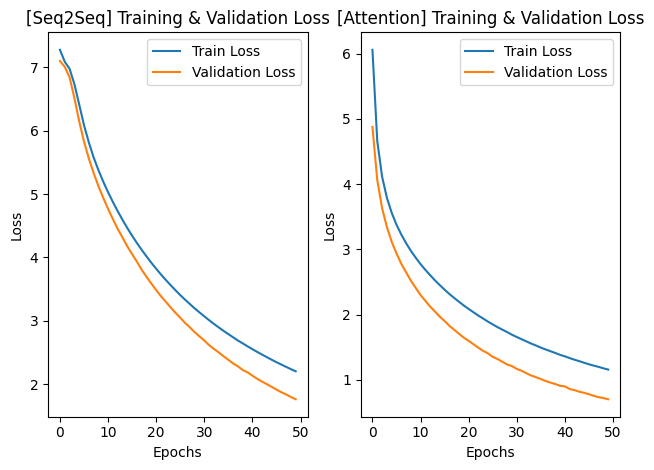

In [38]:
plt.subplot(1, 2, 1)
plt.plot(range(len(each_model_train_losses["seq2seq"])), 
         each_model_train_losses["seq2seq"], 
         label='Train Loss')
plt.plot(range(len(each_model_val_losses["seq2seq"])), 
         each_model_val_losses["seq2seq"], 
         label='Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("[Seq2Seq] Training & Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(range(len(each_model_train_losses["seq2seq_attention"])), 
         each_model_train_losses["seq2seq_attention"], 
         label='Train Loss')
plt.plot(range(len(each_model_val_losses["seq2seq_attention"])), 
         each_model_val_losses["seq2seq_attention"], 
         label='Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("[Attention] Training & Validation Loss")

plt.tight_layout()
plt.show()

# 인퍼런스 모델 구현
- 솔직히 노드를 봐도 이해가 안되고 코드를 봐도 이해가 안된다
- 테스트 데이터는 정답 레이블이 없으므로 디코더가 반복 구조로 동작해야 하기에 모델설계를 별도로 해주어야 한다고 한다.... 그런데 학습한 모델은 그럼 어떻게 되는거지??

In [39]:
# 테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 함
src_index_to_word = {idx: word for word, idx in src_vocab.items()} # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_vocab # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = {idx: word for word, idx in tar_vocab.items()} # 요약 단어 집합에서 정수 -> 단어를 얻음

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
decoder.to(device)

# 인코더 설계
def encode_input(encoder, input_seq):
    encoder_outputs, hidden, cell = encoder(input_seq)
    return encoder_outputs, hidden, cell

# 이전 시점의 상태들을 저장하는 텐서
num_layers = 3  # 디코더 LSTM 레이어 개수 (설정에 맞춰 조정)
batch_size = 1

decoder_state_input_h = torch.zeros((num_layers, batch_size, hidden_size), dtype=torch.float, device=device)
decoder_state_input_c = torch.zeros((num_layers, batch_size, hidden_size), dtype=torch.float, device=device)
decoder_input = torch.zeros((batch_size, 1), dtype=torch.long, device=device)

dec_emb2 = decoder.embedding(decoder_input)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder(decoder_input, decoder_state_input_h, decoder_state_input_c)

In [41]:
class DecoderWithAttention(nn.Module):
    def __init__(self, decoder, attention, hidden_size, vocab_size):
        super(DecoderWithAttention, self).__init__()
        self.decoder = decoder  # 기존 디코더
        self.attention = attention  # 어텐션 레이어
        self.concat = nn.Linear(hidden_size * 2, hidden_size)  # 어텐션 결합 레이어
        self.output_layer = nn.Linear(hidden_size, vocab_size)  # 최종 출력층
        self.softmax = nn.Softmax(dim=-1)  # 소프트맥스

    def forward(self, decoder_inputs, decoder_hidden_state, decoder_state_h, decoder_state_c):
        # 디코더 실행
        decoder_outputs, state_h, state_c = self.decoder(decoder_inputs, decoder_state_h, decoder_state_c)

        # 어텐션 적용
        attn_out = self.attention(decoder_outputs, decoder_hidden_state)

        # 어텐션과 디코더 출력 결합
        decoder_concat_output = torch.cat((decoder_outputs, attn_out), dim=-1)
        decoder_concat_output = torch.tanh(self.concat(decoder_concat_output))

        # 최종 출력층 적용
        decoder_outputs2 = self.softmax(self.output_layer(decoder_concat_output))

        return decoder_outputs2, state_h, state_c

# 기존 Attention 클래스 사용
attention_layer = Attention_dot(hidden_size)

# 디코더 모델 생성
decoder_model = DecoderWithAttention(decoder, attention_layer, hidden_size, tar_vocab_size)

In [42]:
def decode_sequence(input_seq, encoder, decoder, tar_word_to_index, tar_index_to_word, text_max_len, summary_max_len, device):
    # 입력을 PyTorch Tensor로 변환
    input_seq = torch.tensor(input_seq, dtype=torch.long, device=device)

    # 인코더 실행하여 초기 상태(hidden, cell) 얻기
    with torch.no_grad():
        e_out, e_h, e_c = encoder(input_seq)

    e_out = e_out.repeat(1, text_max_len, 1)  # 차원 조정 (np.tile 대신 repeat 사용)

    # <SOS>에 해당하는 토큰 생성
    target_seq = torch.zeros((1, 1), dtype=torch.long, device=device)
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        # 디코더 실행
        with torch.no_grad():
            output_tokens, h, c = decoder(target_seq, e_h, e_c)

        # 가장 높은 확률을 가진 단어 선택
        sampled_token_index = torch.argmax(output_tokens[0, -1, :]).item()
        sampled_token = tar_index_to_word[sampled_token_index]

        if sampled_token != 'eostoken':
            decoded_sentence += ' ' + sampled_token

        # 종료 조건: <eos>에 도달하거나 최대 길이를 초과하면 중단
        if sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (summary_max_len - 1):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = torch.zeros((1, 1), dtype=torch.long, device=device)
        target_seq[0, 0] = sampled_token_index

        # 상태 업데이트
        e_h, e_c = h, c

    return decoded_sentence

# 모델 테스트

In [43]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp = ''
    for i in input_seq:
        key = int(i.item())  # PyTorch Tensor → int 변환
        if key != 0:  # 패딩(0) 제외
            temp = temp + src_index_to_word.get(key, "<UNK>") + ' '  # 안전한 조회
    return temp.strip()

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp = ''
    for i in input_seq:
        key = int(i.item())  # PyTorch Tensor → int 변환
        if key != 0 and key != tar_word_to_index['sostoken'] and key != tar_word_to_index['eostoken']:
            temp = temp + tar_index_to_word.get(key, "<UNK>") + ' '  # 안전한 조회
    return temp.strip()  # 양쪽 공백 제거

In [44]:
%%time
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    input_seq = torch.tensor(encoder_input_test[i], dtype=torch.long, device=device).unsqueeze(0)
    print("예측 요약 :", decode_sequence(input_seq, 
                                        encoder, 
                                        decoder, 
                                        tar_word_to_index, 
                                        tar_index_to_word, 
                                        text_max_len, 
                                        headlines_max_len, 
                                        device))
    print("\n")

원문 : twenty two year old <UNK> <UNK> wa <UNK> born hiv crowned miss congo uk <UNK> discovered hiv positive years old happy least something life story warmed people hearts important thing said
실제 요약 : year old hiv positive model crowned miss congo uk
예측 요약 :  makes prez prez first apple first apple stop stop


원문 : claiming congress approached bsp chief mayawati even decided alliance party mp congress leader jyotiraditya scindia said respect decision however added sometimes partnerships work sometimes mean doors closed forever hope talk time lok sabha elections
실제 요약 : respect mayawati decision hope talk scindia
예측 요약 :  could two make make make make make make hc


원문 : income tax department issued second notice icici bank ceo chanda kochhar husband deepak kochhar received part reply crore icici bank videocon loan case alleged icici loan videocon benefitted deepak authority asked kochhar full information flow crore two mauritius based firms company
실제 요약 : dept issues second notice chan

<timed exec>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\suhol\AppData\Local\Temp\ipykernel_2100\3400655303.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_seq = torch.tensor(input_seq, dtype=torch.long, device=device)


예측 요약 :  two nd days nd nd nd nd nd nd


원문 : credit rating agency fitch wednesday said withdrawn ratings debt ridden reliance communications commercial reasons firm longer provide analytical coverage ratings anil ambani led company earlier moody investors service withdrawn credit rating reliance communications defaulted interest payment bonds
실제 요약 : fitch withdraws rcom ratings commercial reasons
예측 요약 :  show makes days worth worth worth reports kills show


원문 : dry cleaning refers cleaning process clothes uses chemical solvent water clothes loaded device resembling washing machine filled chemical machine stains removed dirt separated solvent removal stains pressing machine removes wrinkles
실제 요약 : process dry cleaning
예측 요약 :  pm rahul days worth amid wins wins arrested students


원문 : us judge monday dismissed pornstar stormy daniels defamation lawsuit president donald trump saying tweet us leader written referring protected free speech laws trump called sketch man released danie

# 추출 요약

In [73]:
from summa.summarizer import summarize

data = pd.read_csv('./news_summary_more.csv', encoding='iso-8859-1')

for i in range(50, 100):
    print("원문 :", data.loc[:, "text"].iloc[i])
    print("실제 요약 :", data.loc[:, "headlines"].iloc[i])
    print("예측 요약 :", summarize(data.loc[:, "text"].iloc[i], ratio=0.4))
    print("\n")

원문 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL). All agencies including regulators of the government have failed to track nefarious deals, he said. This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.
실제 요약 : Yashwant Sinha demands probe into alleged fund diversion by DHFL
예측 요약 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).


원문 : US-based Boeing on Wednesday reported annual sales worth $101.12 billion in 2018, the first time the planemaker's sales crossed the $100-billion mark in its 102-year history. The company said it expects to deliver between 895 and 905 commercial aircraft in 2019. Boeing retained its position as the world's largest planemaker for the seventh straight

에라이 모르겠다.... 둘 다 이상하다!